# Capstone 3 - Modeling


## Hypothesis:  Does inclusion of consumer confiden index (cci) improve model prediction score for sales?  How much does logrithmic transformation of several non-normal distributed features improve predictions?


Procedure:

Part I.

Build and apply column transformer to Train Set-

Nominal Categories: 'IsHoliday', 'Dept'

Ordinal Categories: 'Week','Type'

Standard Scaler for Numerical Features: 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Size','cci_value'


Part II.  Obtain base model performance metrics without cci values.

1. Fit following models without cci data:  Ordinary Least Squares(OLS), ElasticNet, Random Forest Regressor,
XGBoost, HistGradientBoost.
2. Cross validate to obtain coefficient of determination (R2), mean squared error (MSE), and mean average error (MAE) for each model. 

Part III.  Using models from Part I, obtain performance metrics with cci values.
1. Build and test models from Part I with cci data.
2.  Record coefficient of determination (R2), mean squared error (MSE), and mean average error (MAE) for each model. 
3.  Cross validate to obtain R2, MSE, and MAE scores.
4.  Compare R2, MSE, and MAE scores between Parts II and III.

Part IV.  Apply logrithmic function to following features: 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown3',
'MarkDown4', 'MarkDown5'
1.  Create new features by applying logrithmic function to following features: 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown3', 'MarkDown4', 'MarkDown5'.
2.  Drop original "MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", and "MarkDown5" features from Training data.
3.  Fit HistGradientBoost and Random Forest models to training data.
4.  Cross validate to obtain R2, MSE, MAE scores.
5.  Compare R2, MSE MAE scores between II and IV.

Results:


Conclusion:




# Import Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# sklearn libraries

from sklearn.compose import make_column_transformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

from sklearn.model_selection import cross_validate


from sklearn.decomposition import PCA
from sklearn.decomposition import NMF

from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet


from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor


#Model Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC

import xgboost as xgb 

from sklearn.pipeline import Pipeline


/Users/marshallbanana/opt/anaconda3/lib/python3.8/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [3]:
!ls

Capstone 3 Data Wrangling Ed Gatdula.ipynb
Capstone 3 EDA Ed Gatdula.ipynb
Capstone 3 Modeling - Ensemble Regression Models.ipynb
Capstone 3 Modeling - Linear Regression Models Ed Gatdula.ipynb
Capstone 3 Modeling - Regression Model Compilations.ipynb
Capstone 3 Modeling - Results Plots.ipynb
Capstone 3 Modeling - TimeSeriesSplit Version.ipynb
Feature Union Worksheet.ipynb
Kaggle Submissions
Log Transform MarkDown Features.ipynb
Misc Worksheet
capstone 3 project data
capstone_3
capstone_3_test_data
capstone_3_train_data.csv
capstone_3_wrnglng_results
df_metric_results
df_summary_linear
ensemble_scores_temp
features_gbrt.png
kaggle_submission5_randomforest_randomsearchcv
nov_02_xgb_rf_results
random_forest_results.csv
report_images
temp_df


# Import Data


## Test set: OneHotEncode, OrdinalEncoder

In [4]:
# test set for kaggle prediction

df_test = pd.read_csv('./capstone_3_test_data')
print('df_test shape: {}\n'.format(df_test.shape))
df_test.info()
df_test.head()

df_test shape: (115064, 18)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Date          115064 non-null  object 
 1   Store         115064 non-null  int64  
 2   Dept          115064 non-null  int64  
 3   IsHoliday     115064 non-null  int64  
 4   Temperature   115064 non-null  float64
 5   Fuel_Price    115064 non-null  float64
 6   MarkDown1     115064 non-null  float64
 7   MarkDown2     115064 non-null  float64
 8   MarkDown3     115064 non-null  float64
 9   MarkDown4     115064 non-null  float64
 10  MarkDown5     115064 non-null  float64
 11  CPI           115064 non-null  float64
 12  Unemployment  115064 non-null  float64
 13  isocalendar   115064 non-null  object 
 14  Week          115064 non-null  int64  
 15  Type          115064 non-null  object 
 16  Size          115064 non-null  int64  
 17  cci_value     11506

,Date,Store,Dept,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,isocalendar,Week,Type,Size,cci_value
0,2012-11-02,1,1,0,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,"(2012, 44)",44,A,151315,99.00362
1,2012-11-02,1,2,0,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,"(2012, 44)",44,A,151315,99.00362
2,2012-11-02,1,3,0,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,"(2012, 44)",44,A,151315,99.00362
3,2012-11-02,1,4,0,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,"(2012, 44)",44,A,151315,99.00362
4,2012-11-02,1,5,0,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,"(2012, 44)",44,A,151315,99.00362


## Train Set: OneHotEncoder, OrdinalEncoder

Using OrdinalEncoder, OneHotEncoder, StandardScaler to:

1. prepare data for model use
2. prepare columntransformer in pipeline

In [5]:
# training data
df_train = pd.read_csv('./capstone_3_train_data.csv')
print('df_train shape: {}\n'.format(df_train.shape))
df_train.info()
df_train.head()

df_train shape: (421570, 19)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Date          421570 non-null  object 
 1   Store         421570 non-null  int64  
 2   Dept          421570 non-null  int64  
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  int64  
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     421570 non-null  float64
 8   MarkDown2     421570 non-null  float64
 9   MarkDown3     421570 non-null  float64
 10  MarkDown4     421570 non-null  float64
 11  MarkDown5     421570 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  isocalendar   421570 non-null  object 
 15  Week          421570 non-null  int64  
 16  Type          421570 non-null  object 
 17  Size          4215

,Date,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,isocalendar,Week,Type,Size,cci_value
0,2010-02-05,1,1,24924.50,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,"(2010, 5)",5,A,151315,98.22324
1,2010-02-05,1,2,50605.27,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,"(2010, 5)",5,A,151315,98.22324
2,2010-02-05,1,3,13740.12,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,"(2010, 5)",5,A,151315,98.22324
3,2010-02-05,1,4,39954.04,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,"(2010, 5)",5,A,151315,98.22324
4,2010-02-05,1,5,32229.38,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,"(2010, 5)",5,A,151315,98.22324


In [6]:
train_features = df_train.columns.to_list()
train_features

['Date',
 'Store',
 'Dept',
 'Weekly_Sales',
 'IsHoliday',
 'Temperature',
 'Fuel_Price',
 'MarkDown1',
 'MarkDown2',
 'MarkDown3',
 'MarkDown4',
 'MarkDown5',
 'CPI',
 'Unemployment',
 'isocalendar',
 'Week',
 'Type',
 'Size',
 'cci_value']

## Column Transformer Setup


two column_transform objects:

###  column_transform_no_cci

IMPORTANT! drop 'cci_value' from column transformer setup


In [7]:
df_train.shape

(421570, 19)

In [8]:
# column_transform_no_cci
# 'Date', 'Store', 'Dept', 'Weekly_Sales', 'IsHoliday', 'Temperature', 'Fuel_Price', 'MarkDown1',
# 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'isocalendar', 'Week',
# 'Type', 'Size', 'cci_value'

# 3 Nominal Categories: 'IsHoliday', 'Dept','Store'

ohe=OneHotEncoder(handle_unknown='ignore')
ohe.fit_transform(df_train[["IsHoliday",'Dept','Store']])
ohe.categories_

# 3 Ordinal Categories: 'Week', 'Type', 'isocalendar'
oe = OrdinalEncoder()
oe.fit_transform(df_train[['Week','Type', 'isocalendar']])
oe.categories_

# 10 Standard Scaler for Numerical Feature
scaler = StandardScaler()
scaler.fit_transform(df_train[['Temperature', 'Fuel_Price', 'MarkDown1',
                                  'MarkDown2', 'MarkDown3', 'MarkDown4',
                                  'MarkDown5', 'CPI', 'Unemployment', 'Size',
                              #    'cci_value'
                              ]])

# Instantiate make_column_transformer using standard scaler, onehotencoder, ordinalencoder

column_transform_no_cci = make_column_transformer((scaler,['Temperature', 'Fuel_Price','MarkDown1',
                                                              'MarkDown2', 'MarkDown3', 'MarkDown4',
                                                              'MarkDown5', 'CPI', 'Unemployment', 'Size',
                                                          #    'cci_value'
                                                          ]),
                                           (ohe,['IsHoliday','Dept','Store']), 
                                           (oe,['Week','Type','isocalendar']),sparse_threshold=0)

#fit_transform make_column_transformer object
column_transform_no_cci.fit(df_train.drop(columns = ['Date','Weekly_Sales','cci_value']))

ColumnTransformer(sparse_threshold=0,
                  transformers=[('standardscaler', StandardScaler(),
                                 ['Temperature', 'Fuel_Price', 'MarkDown1',
                                  'MarkDown2', 'MarkDown3', 'MarkDown4',
                                  'MarkDown5', 'CPI', 'Unemployment', 'Size']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['IsHoliday', 'Dept', 'Store']),
                                ('ordinalencoder', OrdinalEncoder(),
                                 ['Week', 'Type', 'isocalendar'])])

###  column_transform_cci

IMPORTANT:  Retains Consumer Confidence Index (cci) values

In [9]:
# column_transform_cci
# 'Date', 'Store', 'Dept', 'Weekly_Sales', 'IsHoliday', 'Temperature', 'Fuel_Price', 'MarkDown1',
# 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'isocalendar', 'Week',
# 'Type', 'Size', 'cci_value'

# 3 Nominal Categories: 'IsHoliday', 'Dept','Store'

ohe=OneHotEncoder(handle_unknown='ignore')
ohe.fit_transform(df_train[["IsHoliday",'Dept','Store']])
ohe.categories_

# 3 Ordinal Categories: 'Week', 'Type', 'isocalendar'
oe = OrdinalEncoder()
oe.fit_transform(df_train[['Week','Type', 'isocalendar']])
oe.categories_

# 11 Standard Scaler for Numerical Feature (includes 'cci_value' feature)
scaler = StandardScaler()
scaler.fit_transform(df_train[['Temperature', 'Fuel_Price', 'MarkDown1',
                                  'MarkDown2', 'MarkDown3', 'MarkDown4',
                                  'MarkDown5', 'CPI', 'Unemployment', 'Size',
                                  'cci_value'
                              ]])

# Instantiate make_column_transformer using standard scaler, onehotencoder, ordinalencoder

column_transform_cci = make_column_transformer((scaler,['Temperature', 'Fuel_Price','MarkDown1',
                                                              'MarkDown2', 'MarkDown3', 'MarkDown4',
                                                              'MarkDown5', 'CPI', 'Unemployment', 'Size',
                                                              'cci_value'
                                                          ]),
                                           (ohe,['IsHoliday','Dept','Store']), 
                                           (oe,['Week','Type','isocalendar']),sparse_threshold=0)

#fit_transform make_column_transformer object
column_transform_cci.fit(df_train.drop(columns = ['Date','Weekly_Sales']))



ColumnTransformer(sparse_threshold=0,
                  transformers=[('standardscaler', StandardScaler(),
                                 ['Temperature', 'Fuel_Price', 'MarkDown1',
                                  'MarkDown2', 'MarkDown3', 'MarkDown4',
                                  'MarkDown5', 'CPI', 'Unemployment', 'Size',
                                  'cci_value']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['IsHoliday', 'Dept', 'Store']),
                                ('ordinalencoder', OrdinalEncoder(),
                                 ['Week', 'Type', 'isocalendar'])])

# Random Forest Regression


## Random Forest Regressor (no cci_value) - TimeSeriesSplit cross validation

In [12]:
# split data into test train split
# cross validate base regression model, no cci_value

cv = TimeSeriesSplit(n_splits=5)

Y = df_train['Weekly_Sales']
X = df_train.drop(columns = ['Date','cci_value','Weekly_Sales'])
Z = column_transform_no_cci.fit(df_train.drop(columns = ['Date','cci_value','Weekly_Sales']))

randomforest_no_cci_scores = cross_validate(RandomForestRegressor(), Z.transform(X), Y, cv=cv,
                        scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'), n_jobs=-1)

print("MSE scores: {}".format(randomforest_no_cci_scores['test_neg_mean_squared_error']))
print("R2 scores: {}".format(randomforest_no_cci_scores['test_r2']))
print("MAE scores: {}".format(randomforest_no_cci_scores['test_neg_mean_absolute_error']))

MSE scores: [-4.07553965e+08 -1.37085670e+08 -2.05669963e+08 -1.69657857e+08
 -1.01422857e+08]
R2 scores: [0.43915919 0.71089562 0.570028   0.49938663 0.72647196]
MAE scores: [-9745.24993557 -6149.42349425 -8162.92530431 -7350.72618753
 -5017.51451143]


In [13]:
# write a function that returns average of cross validation scores
list = {}

def scores(name):
    keys = ['test_r2', 'test_neg_mean_squared_error',
            'test_neg_mean_absolute_error']
    for item in keys:
        z = list.update({item: np.round(np.mean(np.abs(name[item])), 2)})
    return list


scores(randomforest_no_cci_scores)

{'test_r2': 0.59,
 'test_neg_mean_squared_error': 204278062.29,
 'test_neg_mean_absolute_error': 7285.17}

In [14]:
# function to write model name and results to a dict.  dict be used to create df_summary entry

def write(description, cv_scores):
    dict1 = {'model description':description}
    dict2 = scores(cv_scores)
    dict2.update(dict1)
    return(dict2)  

In [15]:
# create dataframe to record performance metrics for all models
df_summary = pd.DataFrame(columns = ['name'])
df_summary = df_summary.append(write('randomforest base no cci', randomforest_no_cci_scores), ignore_index=True)
df_summary

,name,model description,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_r2
0,NaN,randomforest base no cci,7285.17,2.042781e+08,0.59


## Random Forest Regressor (cci_value) - TimeSeriesSplit CV 

In [173]:
# split data into test train split
# cross validate base regression model, no cci_value

cv = TimeSeriesSplit(n_splits=5)

Y = df_train['Weekly_Sales']
X = df_train.drop(columns = ['Date','Weekly_Sales'])
Z = column_transform_cci.fit(X)

randomforest_cci_scores = cross_validate(RandomForestRegressor(), Z.transform(X), Y, cv=cv,
                        scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'), n_jobs=-1)

print("MSE scores: {}".format(randomforest_cci_scores['test_neg_mean_squared_error']))
print("R2 scores: {}".format(randomforest_cci_scores['test_r2']))
print("MAE scores: {}".format(randomforest_cci_scores['test_neg_mean_absolute_error']))

# appending metrics to df_summary
scores(randomforest_cci_scores)

score_dict=write('randomforest cci', randomforest_cci_scores)

df_summary=df_summary.append(score_dict, ignore_index=True)
df_summary

KeyboardInterrupt: 

## Random Forest Regressor GridSearchCV

In [17]:
df_summary

,name,model description,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_r2
0,NaN,randomforest base no cci,7285.17,2.042781e+08,0.59
1,NaN,randomforest cci,7264.21,2.020688e+08,0.59


In [18]:
# GridSearchCV Lasso Regressor using column_transform

# create steps

steps = [#('transform', column_transform),
         ('RandomForest', RandomForestRegressor(max_features='sqrt'))]

#instantiate pipeline object
pipe = Pipeline(steps)

Y = df_train['Weekly_Sales']
X = df_train.drop(columns = ['Date','cci_value','Weekly_Sales'])
Z = column_transform_no_cci.fit(X)


# GridSearchCV parameters
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 40, stop = 70, num = 7)]
# Number of features to consider at every split
#max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 10, num = 5)]
#max_depth.append(None)
#max_depth.append(None)

param_grid = {'RandomForest__n_estimators': [75,80,85],
             'RandomForest__max_depth': [45,50,55]}
              
                # 'max_features': max_features,
               #'RandomForest__max_depth': max_depth}
             #  'min_samples_split': min_samples_split,
             #  'min_samples_leaf': min_samples_leaf,
             #  'bootstrap': bootstrap}

print(param_grid)

tscv = TimeSeriesSplit(n_splits=5)
rf_random = GridSearchCV(pipe, param_grid=param_grid, cv = tscv, verbose=1,n_jobs=-1)

# Fit the random search model
rf_random.fit(Z.transform(X),Y)




{'RandomForest__n_estimators': [75, 80, 85], 'RandomForest__max_depth': [45, 50, 55]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/Users/marshallbanana/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('RandomForest',
                                        RandomForestRegressor(max_features='sqrt'))]),
             n_jobs=-1,
             param_grid={'RandomForest__max_depth': [45, 50, 55],
                         'RandomForest__n_estimators': [75, 80, 85]},
             verbose=1)

In [19]:
# gridsearch for max depth only
rf_random.best_params_, rf_random.best_score_

({'RandomForest__max_depth': 50, 'RandomForest__n_estimators': 85},
 0.7012128981167465)

NameError: name 'rf_random' is not defined

In [21]:
# cross validate gridsearchcv model
# cross validate gridsearchcv model
Y = df_train['Weekly_Sales']
X = df_train.drop(columns = ['Date','cci_value','Weekly_Sales'])
Z = column_transform_no_cci.fit(X)


cv = TimeSeriesSplit(n_splits=5)
rf_scores = cross_validate(rf_random, Z.transform(X), Y, cv=cv,
                        scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'), n_jobs=-1)
print(rf_scores['test_neg_mean_squared_error'])
print(rf_scores['test_r2'])
print(rf_scores['test_neg_mean_absolute_error'])

[-2.39410116e+08 -1.05625607e+08 -1.20597589e+08 -1.61330114e+08
 -8.85082284e+07]
[0.67054433 0.77724276 0.74787963 0.5239595  0.76130151]
[-8597.39244074 -6089.48880556 -7223.10534278 -8319.42491558
 -6380.05666237]


In [22]:
# appending metrics to df_summary
scores(rf_scores)

score_dict=write('random forest gridsearch', rf_scores)

df_summary=df_summary.append(score_dict, ignore_index=True)
df_summary

,name,model description,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_r2
0,NaN,randomforest base no cci,7285.17,2.042781e+08,0.59
1,NaN,randomforest cci,7264.21,2.020688e+08,0.59
2,NaN,random forest gridsearch,7321.89,1.430943e+08,0.70


### Random Forest Model Residuals Plot - 

1.  Make prediction using Random Forest Model.
2.  Calculate residuals.  Residual = Predicted Value - Observed value
3.  Plot residuals vs individual features.
4.  Observe scatterplot distribution to determine areas where tuned model is not performing well.

Summary:

The positive value residuals range from 0 to 50000.  The negative residuals are found in the range of 0 to -20000.

'Date' - Three dates produce sizeable number of large residual values. 2010-11-26, 2011-12-23, 2010-12-24			
'Store' - 10, 35 

'Dept' - Departments 72, 7 

'Temperature' - 

'Fuel_Price'

'MarkDown1' - If residuals for MarkDown1 = 0 are omitted, the distribution of residuals appears to be random

'MarkDown2' - If residuals for MarkDown2 = 0 are omitted, the distribution of residuals appears to be random

'MarkDown3' - If residuals for MarkDown3 = 0 are omitted, the distribution of residuals appears to be random

'MarkDown4' - If residuals for MarkDown4 = 0 are omitted, the distribution of residuals appears to be random

'MarkDown5' - If residuals for MarkDown5 = 0 are omitted, the distribution of residuals appears to be random



In [23]:
df_random_forest = df_train
df_random_forest.head()

,Date,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,isocalendar,Week,Type,Size,cci_value
0,2010-02-05,1,1,24924.50,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,"(2010, 5)",5,A,151315,98.22324
1,2010-02-05,1,2,50605.27,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,"(2010, 5)",5,A,151315,98.22324
2,2010-02-05,1,3,13740.12,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,"(2010, 5)",5,A,151315,98.22324
3,2010-02-05,1,4,39954.04,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,"(2010, 5)",5,A,151315,98.22324
4,2010-02-05,1,5,32229.38,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,"(2010, 5)",5,A,151315,98.22324


In [53]:
df_summary



,name,model description,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_r2
0,NaN,randomforest base no cci,7285.17,2.042781e+08,0.59
1,NaN,randomforest cci,7264.21,2.020688e+08,0.59
2,NaN,random forest gridsearch,7321.89,1.430943e+08,0.70
3,NaN,xgb_no_cci_scores,8826.88,1.717879e+08,0.65
4,NaN,xgb_cci_scores,8807.58,1.720648e+08,0.65
5,NaN,xgb_cci_scores,8807.58,1.720648e+08,0.65


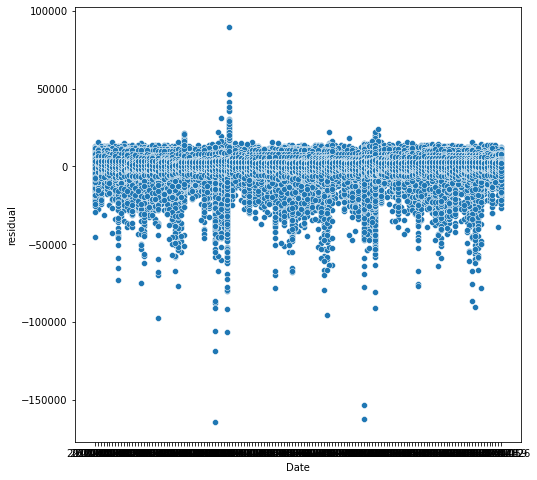

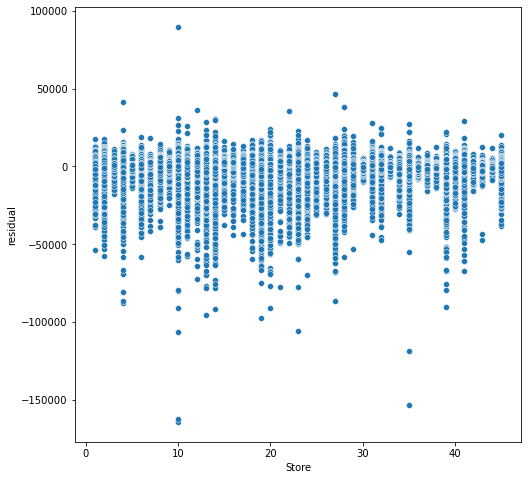

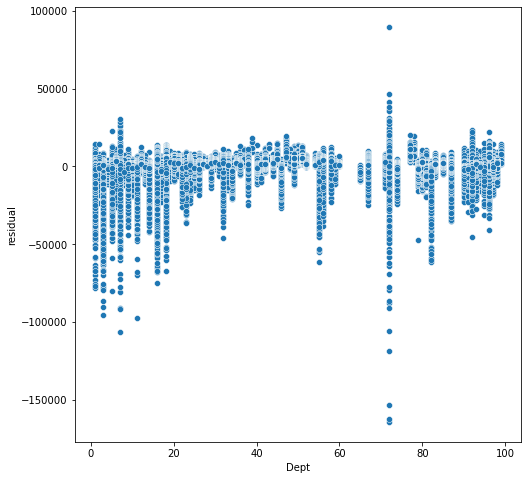

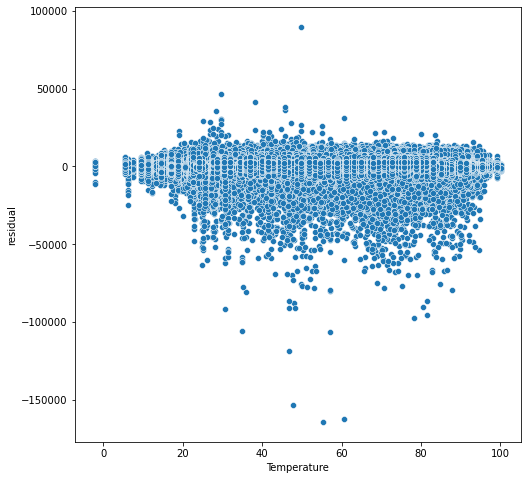

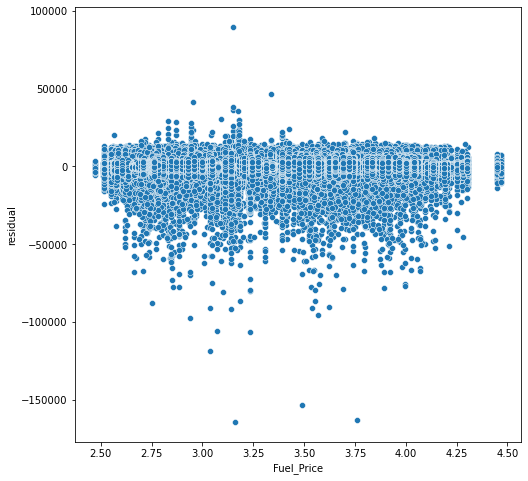

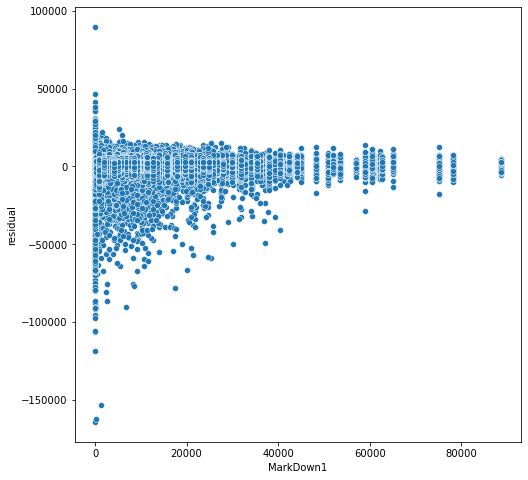

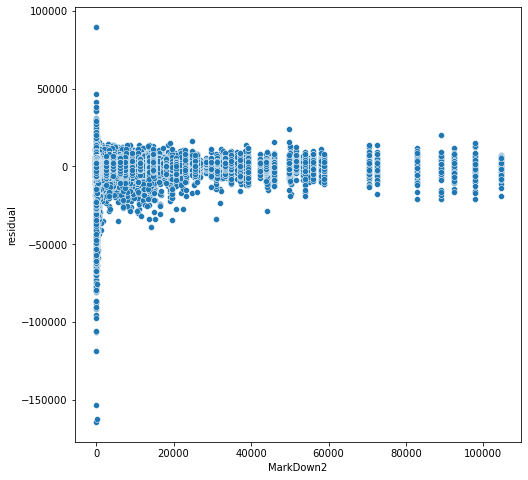

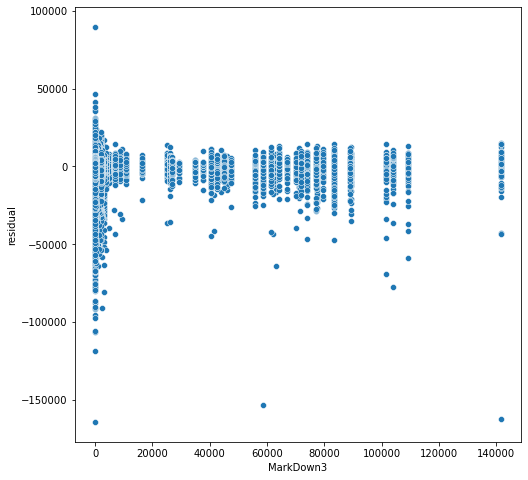

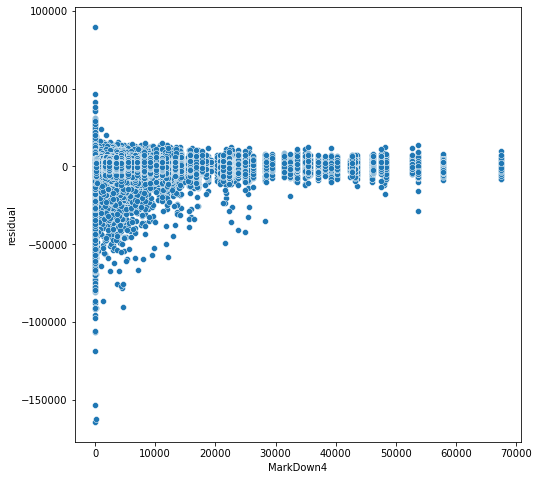

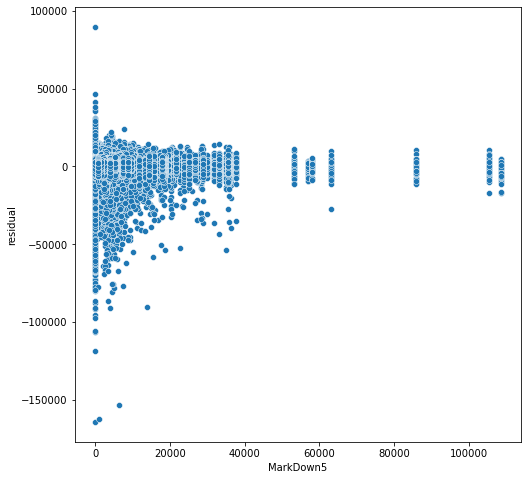

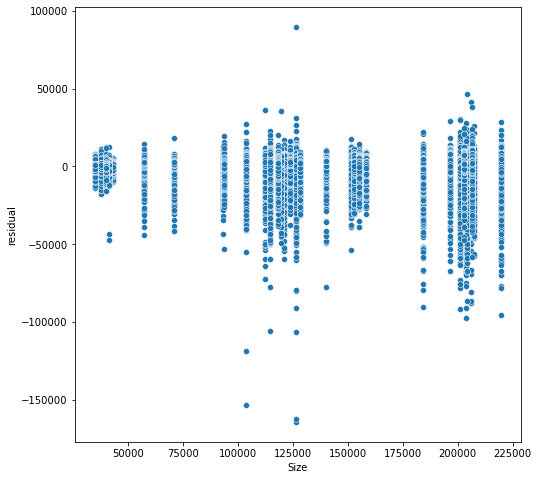

In [24]:
# Calculate residuals
Y = df_train['Weekly_Sales']
X = df_train.drop(columns = ['Date','cci_value','Weekly_Sales'])
Z = column_transform_no_cci.fit(X)

y_pred = rf_random.predict(Z.transform(X))

df_random_forest['y_pred'] = y_pred
df_random_forest['residual'] = y_pred - df_random_forest['Weekly_Sales']

# Plot Residuals For Each Random Forest Model Feature

features_list = ['Date', 'Store', 'Dept', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3',
                'MarkDown4', 'MarkDown5', 'Size']

for i in features_list:    
    plt.figure(figsize=(8,8))
    sns.scatterplot(data=df_random_forest, x=i, y='residual' )
    plt.show()

In [25]:
# residual outliers lie below -90000 limit

df_random_forest[df_random_forest['residual'] <= -90000].sort_values('residual')

,Date,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,MarkDown5,CPI,Unemployment,isocalendar,Week,Type,Size,cci_value,y_pred,residual
90645,2010-11-26,10,72,693099.36,1,55.33,3.162,0.00,0.00,0.00,...,0.00,126.669267,9.003,"(2010, 47)",47,B,126512,97.90868,528668.636187,-164430.723813
94393,2011-11-25,10,72,630999.19,1,60.68,3.760,174.72,329.00,141630.61,...,1009.98,129.836400,7.874,"(2011, 47)",47,B,126512,97.01297,468221.737070,-162777.452930
337053,2011-11-25,35,72,649770.18,1,47.88,3.492,1333.24,0.00,58563.24,...,6386.86,140.421786,8.745,"(2011, 47)",47,B,103681,97.01297,496492.635059,-153277.544941
333594,2010-11-26,35,72,627962.93,1,46.67,3.039,0.00,0.00,0.00,...,0.00,136.689571,8.763,"(2010, 47)",47,B,103681,97.90868,509283.587164,-118679.342836
90886,2010-12-24,10,7,406988.63,0,57.06,3.236,0.00,0.00,0.00,...,0.00,126.983581,9.003,"(2010, 51)",51,B,126512,98.19749,300378.609108,-106610.020892
219800,2010-11-26,23,72,369830.98,1,34.95,3.070,0.00,0.00,0.00,...,0.00,132.836933,5.287,"(2010, 47)",47,B,114533,97.90868,264211.038842,-105619.941158
178778,2010-07-09,19,11,119483.37,0,78.22,2.940,0.00,0.00,0.00,...,0.00,132.546133,8.099,"(2010, 27)",27,A,203819,97.75742,22005.975434,-97477.394566
123551,2011-08-26,13,3,131564.25,0,81.53,3.570,0.00,0.00,0.00,...,0.00,129.283258,6.877,"(2011, 34)",34,A,219622,96.31504,35705.975673,-95858.274327
131321,2010-12-24,14,7,356867.25,0,30.59,3.141,0.00,0.00,0.00,...,0.00,182.544590,8.724,"(2010, 51)",51,A,200898,98.19749,264888.789041,-91978.460959
94634,2011-12-23,10,7,341308.00,0,48.36,3.541,300.02,77.73,2432.01,...,4078.21,129.984548,7.874,"(2011, 51)",51,B,126512,97.64204,250199.493878,-91108.506122


# XGBoost Regressor 
## XGBoost (no cci_value), time series split cross validation

In [26]:

# split data into test train split
# cross validate base regression model, no cci_value

cv = TimeSeriesSplit(n_splits=5)

Y = df_train['Weekly_Sales']
X = df_train.drop(columns = ['Date','cci_value','Weekly_Sales'])
Z = column_transform_no_cci.fit(df_train.drop(columns = ['Date','cci_value','Weekly_Sales']))

xgb_no_cci_scores = cross_validate(GradientBoostingRegressor(), Z.transform(X), Y, cv=cv,
                        scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'), n_jobs=-1)

print("MSE scores: {}".format(xgb_no_cci_scores['test_neg_mean_squared_error']))
print("R2 scores: {}".format(xgb_no_cci_scores['test_r2']))
print("MAE scores: {}".format(xgb_no_cci_scores['test_neg_mean_absolute_error']))

MSE scores: [-3.23797046e+08 -1.47809490e+08 -1.50446401e+08 -1.26518453e+08
 -1.10368136e+08]
R2 scores: [0.55441828 0.68827982 0.68547794 0.62667907 0.70234737]
MAE scores: [-11316.62337025  -8203.99043315  -9034.12759313  -8061.86334813
  -7517.79237417]


In [27]:
# appending metrics to df_summary
scores(xgb_no_cci_scores)

score_dict=write('xgb_no_cci_scores', xgb_no_cci_scores)

df_summary=df_summary.append(score_dict, ignore_index=True)
df_summary

,name,model description,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_r2
0,NaN,randomforest base no cci,7285.17,2.042781e+08,0.59
1,NaN,randomforest cci,7264.21,2.020688e+08,0.59
2,NaN,random forest gridsearch,7321.89,1.430943e+08,0.70
3,NaN,xgb_no_cci_scores,8826.88,1.717879e+08,0.65


## XGBoost (cci values) TimeSeriesSplit Cross-Validation

In [28]:
# split data into test train split
# cross validate base regression model, no cci_value

cv = TimeSeriesSplit(n_splits=5)

Y = df_train['Weekly_Sales']
X = df_train.drop(columns = ['Date','Weekly_Sales'])
Z = column_transform_cci.fit(X)

xgb_cci_scores = cross_validate(GradientBoostingRegressor(), Z.transform(X), Y, cv=cv,
                        scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'), n_jobs=-1)

print("MSE scores: {}".format(xgb_cci_scores['test_neg_mean_squared_error']))
print("R2 scores: {}".format(xgb_cci_scores['test_r2']))
print("MAE scores: {}".format(xgb_cci_scores['test_neg_mean_absolute_error']))


MSE scores: [-3.22804201e+08 -1.47873448e+08 -1.50869322e+08 -1.28408787e+08
 -1.10368136e+08]
R2 scores: [0.55578455 0.68814493 0.68459379 0.62110122 0.70234737]
MAE scores: [-11197.35664069  -8216.30554057  -9035.44012966  -8071.00313028
  -7517.79237417]


In [29]:
# appending metrics to df_summary
scores(xgb_cci_scores)

score_dict=write('xgb_cci_scores',xgb_cci_scores)

df_summary=df_summary.append(score_dict, ignore_index=True)
df_summary

,name,model description,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_r2
0,NaN,randomforest base no cci,7285.17,2.042781e+08,0.59
1,NaN,randomforest cci,7264.21,2.020688e+08,0.59
2,NaN,random forest gridsearch,7321.89,1.430943e+08,0.70
3,NaN,xgb_no_cci_scores,8826.88,1.717879e+08,0.65
4,NaN,xgb_cci_scores,8807.58,1.720648e+08,0.65


## XGBoost Regressor - TimeSeriesSplit, GridSearchCV

In [10]:
reg = GradientBoostingRegressor(random_state=0)
reg.get_params().keys()

dict_keys(['alpha', 'ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [11]:
# GridSearchCV Example

# GridSearchCV xgbboost Regressor using column_transform

# create steps
steps = [#('transform', column_transform),
        ('xgb', GradientBoostingRegressor())]


#instantiate pipeline object
pipe = Pipeline(steps)

# Create the parameter grid: gbm_param_grid
gbm_param_grid = {'xgb__learning_rate': [0.5,0.6],
                  'xgb__n_estimators' : [60,70],
                  'xgb__max_depth'    : [8]
                 }

   # split df_train into test and train sets 
# Column Transform df_train before split
Y = df_train['Weekly_Sales']
X = df_train.drop(columns = ['Date','cci_value','Weekly_Sales'])
Z = column_transform_no_cci.fit(df_train.drop(columns = ['Date','cci_value','Weekly_Sales']))

# Perform grid search
cv = TimeSeriesSplit(n_splits=5)
xgb_gridsearch = GridSearchCV(pipe, param_grid=gbm_param_grid, cv=cv, verbose=1,
                             n_jobs=-1)


# Fit grid_mse to the data
xgb_gridsearch.fit(Z.transform(X),Y)


Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('xgb', GradientBoostingRegressor())]),
             n_jobs=-1,
             param_grid={'xgb__learning_rate': [0.5, 0.6],
                         'xgb__max_depth': [8], 'xgb__n_estimators': [60, 70]},
             verbose=1)

In [12]:
xgb= GradientBoostingRegressor(learning_rate= 0.6,max_depth= 8, n_estimators= 70)

Y = df_train['Weekly_Sales']
X = df_train.drop(columns = ['Date','cci_value','Weekly_Sales'])
Z = column_transform_no_cci.fit(df_train.drop(columns = ['Date','cci_value','Weekly_Sales']))

xgb.fit(Z.transform(X), Y)

GradientBoostingRegressor(learning_rate=0.6, max_depth=8, n_estimators=70)

## figure out features from xgboost

In [23]:
Z.fit(X).get_feature_names_out

<bound method ColumnTransformer.get_feature_names_out of ColumnTransformer(sparse_threshold=0,
                  transformers=[('standardscaler', StandardScaler(),
                                 ['Temperature', 'Fuel_Price', 'MarkDown1',
                                  'MarkDown2', 'MarkDown3', 'MarkDown4',
                                  'MarkDown5', 'CPI', 'Unemployment', 'Size']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['IsHoliday', 'Dept', 'Store']),
                                ('ordinalencoder', OrdinalEncoder(),
                                 ['Week', 'Type', 'isocalendar'])])>

In [24]:
Z.fit(X).output_indices_

{'standardscaler': slice(0, 10, None),
 'onehotencoder': slice(10, 138, None),
 'ordinalencoder': slice(138, 141, None),
 'remainder': slice(0, 0, None)}

In [155]:
len(xgb.feature_importances_)

141

### Standard Scaler Features

In [57]:
# Standard Scaler Features Values
# There are 10 scaled features
std_scaler_values = xgb.feature_importances_[0:10]
std_scaler_values

array([0.00461331, 0.00124322, 0.00044054, 0.00021698, 0.00351436,
       0.00085807, 0.00054331, 0.0077672 , 0.0046786 , 0.20486997])

In [139]:
#Check Standard Scaler names
process = StandardScaler()
scaler_process = process.fit(df_train[['Temperature', 'Fuel_Price', 'MarkDown1',
                                  'MarkDown2', 'MarkDown3', 'MarkDown4',
                                  'MarkDown5', 'CPI', 'Unemployment', 'Size']])

In [141]:
np.array(scaler_process.feature_names_in_).tolist()

['Temperature',
 'Fuel_Price',
 'MarkDown1',
 'MarkDown2',
 'MarkDown3',
 'MarkDown4',
 'MarkDown5',
 'CPI',
 'Unemployment',
 'Size']

In [ ]:
# Ordinalencoder Feature Values -> xgb.features_importance index range (138,141)
# 138 

ordinal_feature_values = xgb.feature_importances_[138:141]

In [77]:
process = OrdinalEncoder()
ordinal_process = process.fit(df_train[['Week', 'Type', 'isocalendar']])

In [ ]:
ordinal_process.categories_

In [120]:
np.array(ordinal_process.categories_[2][0:143]).tolist()

['(2010, 10)',
 '(2010, 11)',
 '(2010, 12)',
 '(2010, 13)',
 '(2010, 14)',
 '(2010, 15)',
 '(2010, 16)',
 '(2010, 17)',
 '(2010, 18)',
 '(2010, 19)',
 '(2010, 20)',
 '(2010, 21)',
 '(2010, 22)',
 '(2010, 23)',
 '(2010, 24)',
 '(2010, 25)',
 '(2010, 26)',
 '(2010, 27)',
 '(2010, 28)',
 '(2010, 29)',
 '(2010, 30)',
 '(2010, 31)',
 '(2010, 32)',
 '(2010, 33)',
 '(2010, 34)',
 '(2010, 35)',
 '(2010, 36)',
 '(2010, 37)',
 '(2010, 38)',
 '(2010, 39)',
 '(2010, 40)',
 '(2010, 41)',
 '(2010, 42)',
 '(2010, 43)',
 '(2010, 44)',
 '(2010, 45)',
 '(2010, 46)',
 '(2010, 47)',
 '(2010, 48)',
 '(2010, 49)',
 '(2010, 5)',
 '(2010, 50)',
 '(2010, 51)',
 '(2010, 52)',
 '(2010, 6)',
 '(2010, 7)',
 '(2010, 8)',
 '(2010, 9)',
 '(2011, 1)',
 '(2011, 10)',
 '(2011, 11)',
 '(2011, 12)',
 '(2011, 13)',
 '(2011, 14)',
 '(2011, 15)',
 '(2011, 16)',
 '(2011, 17)',
 '(2011, 18)',
 '(2011, 19)',
 '(2011, 2)',
 '(2011, 20)',
 '(2011, 21)',
 '(2011, 22)',
 '(2011, 23)',
 '(2011, 24)',
 '(2011, 25)',
 '(2011, 26)',
 '

In [163]:
#standard scaler columns 

_a = np.array(scaler_process.feature_names_in_).tolist()

#onehotencode ['IsHoliday', 'Dept', 'Store'] -> 128 columns

_b = np.array(z.get_feature_names_out()).tolist()

#ordinal encode ['Week', 'Type', 'isocalendar'] -> 3 columns

#Type
_c = np.array(ordinal_process.categories_[1][0:3]).tolist()

features_list = (_a + _b + _c)
features_list  #use features_list as index for xgb.feature_importances_

['Temperature',
 'Fuel_Price',
 'MarkDown1',
 'MarkDown2',
 'MarkDown3',
 'MarkDown4',
 'MarkDown5',
 'CPI',
 'Unemployment',
 'Size',
 'IsHoliday_0',
 'IsHoliday_1',
 'Dept_1',
 'Dept_2',
 'Dept_3',
 'Dept_4',
 'Dept_5',
 'Dept_6',
 'Dept_7',
 'Dept_8',
 'Dept_9',
 'Dept_10',
 'Dept_11',
 'Dept_12',
 'Dept_13',
 'Dept_14',
 'Dept_16',
 'Dept_17',
 'Dept_18',
 'Dept_19',
 'Dept_20',
 'Dept_21',
 'Dept_22',
 'Dept_23',
 'Dept_24',
 'Dept_25',
 'Dept_26',
 'Dept_27',
 'Dept_28',
 'Dept_29',
 'Dept_30',
 'Dept_31',
 'Dept_32',
 'Dept_33',
 'Dept_34',
 'Dept_35',
 'Dept_36',
 'Dept_37',
 'Dept_38',
 'Dept_39',
 'Dept_40',
 'Dept_41',
 'Dept_42',
 'Dept_43',
 'Dept_44',
 'Dept_45',
 'Dept_46',
 'Dept_47',
 'Dept_48',
 'Dept_49',
 'Dept_50',
 'Dept_51',
 'Dept_52',
 'Dept_54',
 'Dept_55',
 'Dept_56',
 'Dept_58',
 'Dept_59',
 'Dept_60',
 'Dept_65',
 'Dept_67',
 'Dept_71',
 'Dept_72',
 'Dept_74',
 'Dept_77',
 'Dept_78',
 'Dept_79',
 'Dept_80',
 'Dept_81',
 'Dept_82',
 'Dept_83',
 'Dept_85',
 '

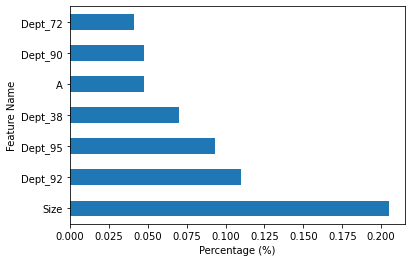

In [172]:
# plot the 7 most important features 

fig, ax = plt.subplots()


feat_importances = pd.Series((xgb.feature_importances_), index = (features_list))
ax = feat_importances.nlargest(7).plot(kind='barh')

ax.set_xlabel("Percentage (%)")
ax.set_ylabel("Feature Name")

# Add the legend and show the Figure
#ax.legend()
plt.savefig('features_gbrt.png', bbox_inches="tight")
plt.show();

# HistGradientBoosting

## HistGradientBoosting (no cci_value) - TimeSeriesSplit, Manual Cross-Validation

In [ ]:
# split data into test train split
# cross validate base regression model, no cci_value

cv = TimeSeriesSplit(n_splits=5)

Y = df_train['Weekly_Sales']
X = df_train.drop(columns = ['Date','cci_value','Weekly_Sales'])
Z = column_transform_no_cci.fit(df_train.drop(columns = ['Date','cci_value','Weekly_Sales']))

hist_gradient_no_cci_scores = cross_validate(HistGradientBoostingRegressor(), Z.transform(X), Y, cv=cv,
                        scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'))

print("MSE scores: {}".format(hist_gradient_no_cci_scores['test_neg_mean_squared_error']))
print("R2 scores: {}".format(hist_gradient_no_cci_scores['test_r2']))
print("MAE scores: {}".format(hist_gradient_no_cci_scores['test_neg_mean_absolute_error']))

In [ ]:
# appending metrics to df_summary
scores(hist_gradient_no_cci_scores)

score_dict=write('histgradientboost no cci',hist_gradient_no_cci_scores)

df_summary=df_summary.append(score_dict, ignore_index=True)
df_summary

##  HistGradientBoosting (cci_value) - TimeSeriesSplit, Manual Cross-Validation

In [ ]:
# split data into test train split
# cross validate base regression model, no cci_value

cv = TimeSeriesSplit(n_splits=5)

Y = df_train['Weekly_Sales']
X = df_train.drop(columns = ['Date','Weekly_Sales'])
Z = column_transform_cci.fit(X)

hist_grad_cci_scores = cross_validate(HistGradientBoostingRegressor(), Z.transform(X), Y, cv=cv,
                        scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'))

print("MSE scores: {}".format(hist_grad_cci_scores['test_neg_mean_squared_error']))
print("R2 scores: {}".format(hist_grad_cci_scores['test_r2']))
print("MAE scores: {}".format(hist_grad_cci_scores['test_neg_mean_absolute_error']))


In [ ]:
# appending metrics to df_summary
scores(hist_grad_cci_scores)

score_dict=write('hist_grad_cci_scores', hist_grad_cci_scores)

df_summary=df_summary.append(score_dict, ignore_index=True)
df_summary

## HistGradientBoost GridSearch

In [ ]:
# GridSearchCV Example

# GridSearchCV xgboost Regressor using column_transform_no_cci

# create steps
steps = [#('transform', column_transform),
        ('hist', HistGradientBoostingRegressor())]


#instantiate pipeline object
pipe = Pipeline(steps)

# Create the parameter grid: gbm_param_grid
gbm_param_grid = {'hist__learning_rate': [0.01,0.2],
                'hist__max_depth'    : [8,10]
                 }

# split df_train into test and train sets 
Y = df_train['Weekly_Sales']
X = df_train.drop(columns = ['Date','Weekly_Sales','cci_value'])
Z = column_transform_no_cci.fit(X)

# Perform grid search: grid_mse
cv = TimeSeriesSplit(n_splits=5)
hist_gridsearch = GridSearchCV(pipe, param_grid=gbm_param_grid, cv=cv,
                               verbose=1)

# Fit hist_gridsearch to the data
hist_gridsearch.fit(Z.transform(X),Y)



In [ ]:
# cross validate gridsearchcv model

# cross validate gridsearchcv model
# split df_train into test and train sets 
# Column Transform df_train before split
Y = df_train['Weekly_Sales']
X = df_train.drop(columns = ['Date','cci_value','Weekly_Sales'])
Z = column_transform_no_cci.fit(X)

cv = TimeSeriesSplit(n_splits=5)
hist_scores = cross_validate(hist_gridsearch, Z.transform(X), Y, cv=cv,
                        scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'), n_jobs=-1)
print(hist_scores['test_neg_mean_squared_error'])
print(hist_scores['test_r2'])
print(hist_scores['test_neg_mean_absolute_error'])




In [ ]:
# appending metrics to df_summary
scores(hist_scores)

score_dict=write('histgradient_scores', hist_scores)

df_summary=df_summary.append(score_dict, ignore_index=True)
df_summary

In [ ]:
df_summary

# Feature Engineering to Improve Predictions

General Procedure:

1.  Create MarkDown_log Feature.  Apply logrithmic function to all non zero MarkDown values.
2.  Drop MarkDown1, MarkDown2, MarkDown3, MarkDown4, MarkDown5 features for HistGradientBoost GridSearch.
3.  Drop MarkDown1, MarkDown2, MarkDown3, MarkDown4, MarkDown5 features for ElasticNet GridSearch.

Engineered Features Summary:

|    | model              |   R2 |   Mean Squared Error, MSE |   Mean Absolute Error, MAE |
|---:|:-------------------|-----:|--------------------------:|---------------------------:|
|  0 | ElasticNet         | 0.26 |               3.6639e+08  |                   13065.3  |
|  1 | ElasticNet+        | 0.27 |               3.52625e+08 |                   12828.1  |
|  2 | HistGradientBoost  | 0.62 |               1.84274e+08 |                    8168.48 |
|  3 | HistGradientBoost+ | 0.63 |               1.78486e+08 |                    7996.65 |

ElasticNet Metric Effects:  
*  3.8% increase Coefficient of Determination. 
*  3.8% reduction Mean Squared Error.  
*  1.8% reduction Mean Absolute Error.  
    
HistGradientBoost Metric Effects:  
*  0.016% increase Coefficient of Determination.  
*  3.0% reduction Mean Square Error.  
*  2.0% reudction Mean Absolute Error.  




In [ ]:
df_summary

In [ ]:
# Create new features by apply logrithmic function to all non zero MarkDown values.  By doing so, the distribution
# MarkDown values will become more normalized.

list = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']
names = [x +"_log" for x in list]

# create new columns containing log values of respective MarkDowns

for x_, y_ in zip(names, list):
#   print(x_, y_)
    df_train[x_]=[np.log(x) if x > 0 else 0 for x in df_train[y_]]

df_train    

# plot function to compare new features.

def compare_plot(before, after):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5), sharey=True)

    sns.histplot(data=df_train[df_train[before]!=0], x=df_train[df_train[before]!=0][before], ax=ax1)
    #ax1.set(xlabel="High End", ylim=(0,10000), title="Salaries")


    sns.histplot(data=df_train[df_train[after]!=0],
    x=df_train[df_train[after]!=0][after], ax=ax2)

    plt.show()
    
compare_plot('MarkDown1', 'MarkDown1_log')

for x_, y_ in zip(names, list):
    compare_plot(y_, x_)

In [ ]:
# Use log transformed values in place of original MarkDown Features. no cci values

In [ ]:
# Nominal Categories: 'IsHoliday', 'Dept'

ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit_transform(df_train[["IsHoliday",'Dept','Store','Type','isocalendar']])
ohe.categories_

# Ordinal Categories: 'Week','Type'
oe = OrdinalEncoder()
oe.fit_transform(df_train[['Week']])
oe.categories_

# Standard Scaler for Numerical Features
scaler = StandardScaler()
scaler.fit_transform(df_train[['Temperature', 'Fuel_Price', 'MarkDown1_log', 'MarkDown2_log', "MarkDown3_log",
                               "MarkDown4_log", "MarkDown5_log", 'CPI', 'Unemployment', 'Size']])
                               #'cci_value']])

# Instantiate make_column_transformer using standard scaler, onehotencoder, ordinalencoder

column_transform_log = make_column_transformer((scaler, ['Temperature', 'Fuel_Price', 'MarkDown1_log', 'MarkDown2_log', "MarkDown3_log",
                                                     "MarkDown4_log", "MarkDown5_log", 'CPI', 'Unemployment', 'Size',]),
                                                     #'cci_value']),
                                           (ohe, ["IsHoliday",'Dept','Store','Type','isocalendar']),
                                           (oe, ['Week', 'Type']), sparse_threshold=0)
column_transform_log

## HistGradientBoosting with Engineered Feature

In [ ]:
# split df_train into test and train set
X = df_train.drop(columns=['Weekly_Sales','Date', 'cci_value','MarkDown1', 'MarkDown2',
                                                          'MarkDown3', 'MarkDown4','MarkDown5',])
Y = df_train['Weekly_Sales']
Z = column_transform_log.fit(X)

histgradient_feature_basic = cross_validate(HistGradientBoostingRegressor(), Z.transform(X), Y, cv=cv,
                        scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'), n_jobs=-1)

print("MSE scores: {}".format(histgradient_feature_basic['test_neg_mean_squared_error']))
print("R2 scores: {}".format(histgradient_feature_basic['test_r2']))
print("MAE scores: {}".format(histgradient_feature_basic['test_neg_mean_absolute_error']))

In [ ]:
# appending metrics to df_summary
scores(histgradient_feature_basic)

score_dict=write('histgradient_feature_basic_scores', histgradient_feature_basic)

df_summary=df_summary.append(score_dict, ignore_index=True)
df_summary

## HistGradientBoosting GridSearch with Engineered Feature

In [ ]:
# GridSearchCV HistGradientBoosting Regressor using column_transform

# create steps
steps = [  # ('transform', column_transform),
    ('hist', HistGradientBoostingRegressor())]


# instantiate pipeline object
pipe = Pipeline(steps)

# Create the parameter grid: gbm_param_grid
hist_param_grid = {'hist__learning_rate': [0.01,0.2],
                  #'hist__min_samples_leaf' : [30,40,50],
                    'hist__max_depth'    : [8,10]
                 }



# split df_train into test and train set
X = df_train.drop(columns=['Weekly_Sales','Date', 'cci_value','MarkDown1', 'MarkDown2',
                                                          'MarkDown3', 'MarkDown4','MarkDown5',])
Y = df_train['Weekly_Sales']
Z = column_transform_log.fit(X)


# Perform grid search: grid_mse
cv = TimeSeriesSplit(n_splits=5)
hist_feature_gridsearch = GridSearchCV(pipe, param_grid=hist_param_grid, cv=cv,
                              verbose=1, n_jobs=-1)
#GridSearchCV(pipe, param_grid, cv=5, return_train_score = True)

# Fit grid_mse to the data
hist_feature_gridsearch.fit(Z.transform(X), Y)

In [ ]:
hist_feature_gridsearch.best_params_

In [ ]:
#learning rate only
hist_feature_gridsearch.best_params_,hist_feature_gridsearch.best_score_

In [ ]:
#min samples leaf
hist_feature_gridsearch.best_params_, hist_feature_gridsearch.best_score_

In [ ]:
# cross validate gridsearchcv model
# split df_train into test and train set
X = df_train.drop(columns=['Weekly_Sales','Date', 'cci_value','MarkDown1', 'MarkDown2',
                                                          'MarkDown3', 'MarkDown4','MarkDown5'])
Y = df_train['Weekly_Sales']
Z = column_transform_log.fit(X)


cv = TimeSeriesSplit(n_splits=5)
hist_feature_scores = cross_validate(hist_feature_gridsearch, Z.transform(X), Y, cv=cv,
                        scoring=('r2',
                                # 'neg_mean_squared_error',
                                # 'neg_mean_absolute_error'
                                ), n_jobs=-1)
#print(hist_feature_scores['test_neg_mean_squared_error'])
print(hist_feature_scores['test_r2'])
#print(hist_feature_scores['test_neg_mean_absolute_error'])



In [ ]:
# appending metrics to df_summary
scores(hist_feature_scores)

score_dict=write('histgradient with log feature scores', hist_feature_scores)

df_summary=df_summary.append(score_dict, ignore_index=True)
df_summary

## ElasticNet using Engineered Feature

In [ ]:
# split df_train into test and train set
X = df_train.drop(columns=['Weekly_Sales','Date', 'cci_value','MarkDown1', 'MarkDown2',
                                                          'MarkDown3', 'MarkDown4','MarkDown5',])
Y = df_train['Weekly_Sales']
Z = column_transform_log.fit(X)

elasticnet_feature_basic = cross_validate(ElasticNet(), Z.transform(X), Y, cv=cv,
                        scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'), n_jobs=-1)

print("MSE scores: {}".format(elasticnet_feature_basic['test_neg_mean_squared_error']))
print("R2 scores: {}".format(elasticnet_feature_basic['test_r2']))
print("MAE scores: {}".format(elasticnet_feature_basic['test_neg_mean_absolute_error']))

In [ ]:
# appending metrics to df_summary
scores(elasticnet_feature_basic)

score_dict=write('elasticnet basic with log feature scores', elasticnet_feature_basic)

df_summary=df_summary.append(score_dict, ignore_index=True)
df_summary

In [ ]:
df_summary

In [ ]:
df_summary.to_csv('temp_df', index=False)

## ElasticNet GridSearchCV using Engineered Feature

In [ ]:
# create steps

steps = [#('transform', column_transform),
         ('linear',ElasticNet())]

#instantiate pipeline object
pipe = Pipeline(steps)

# split df_train into test and train sets 
# Column Transform df_train before split
# split df_train into test and train set
# split df_train into test and train set
X = df_train.drop(columns=['Weekly_Sales','Date', 'cci_value','MarkDown1', 'MarkDown2',
                                                          'MarkDown3', 'MarkDown4','MarkDown5',])
Y = df_train['Weekly_Sales']
Z = column_transform_log.fit(X)



# GridSearchCV parameters
param_grid = {'linear__alpha':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]}

scoring = {'R2': 'r2_score', 'MAE': 'mean_absolute_error', 'MSE': 'mean_squared_error'}

cv = TimeSeriesSplit(n_splits=5)
# instantiate GridSearchCV object using pipeline, parameters dict
elasticnet_feature_gridsearch = GridSearchCV(pipe, param_grid, cv=cv, return_train_score = True)
elasticnet_feature_gridsearch.fit(Z.transform(X), Y)


In [ ]:
# cross validate gridsearchcv model
X = df_train.drop(columns=['Weekly_Sales','Date', 'cci_value','MarkDown1', 'MarkDown2',
                                                          'MarkDown3', 'MarkDown4','MarkDown5',])
Y = df_train['Weekly_Sales']
Z = column_transform_log.fit(X)

cv = TimeSeriesSplit(n_splits=5)

elasticnet_feature_scores = cross_validate(elasticnet_feature_gridsearch, Z.transform(X), Y, cv=cv,
                        scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'), n_jobs=-1)
print(elasticnet_feature_scores['test_neg_mean_squared_error'])
print(elasticnet_feature_scores['test_r2'])
print(elasticnet_feature_scores['test_neg_mean_absolute_error'])



In [ ]:
scores(elasticnet_feature_scores)

In [ ]:
# appending metrics to df_summary
scores(elasticnet_feature_scores)

score_dict=write('elasticnet log feature scores', elasticnet_feature_scores)

df_summary=df_summary.append(score_dict, ignore_index=True)
df_summary

In [ ]:
df_summary.to_csv('temp_df', index=False)

## Comparing Model Improvement with Engineered Feature

In [ ]:
#write a function that returns scores
list = {}
def scores(name):

    keys = ['test_r2','test_neg_mean_squared_error', 'test_neg_mean_absolute_error']
    for item in keys:
        #print("{} average: {:.3f}".format(item, np.mean(np.abs(name[item])) ))
        z = list.update({item:[np.round(np.mean(np.abs(name[item])),2)]})

    return list

scores(lr_scores)

In [ ]:
# Comparison of Tuned Models Performance

# build dataframe: model name, r2, mae, mse features
names = ['ElasticNet', 'ElasticNet+', 'HistGradientBoost', 'HistGradientBoost+']
scores_list = [elastic_scores,elasticnet_feature_scores,hist_scores,hist_feature_scores]

df_scores = pd.DataFrame()
for x, y in zip(names, scores_list):
    df_ = pd.DataFrame(scores(y))
 
    df_['model'] = x
    
    df_scores= df_scores.append(df_)
    
    #print(df_)

df_scores=df_scores.reset_index(drop=True)
df_scores = df_scores[['model','test_r2',
 'test_neg_mean_squared_error',
 'test_neg_mean_absolute_error']]
df_scores = df_scores.rename(columns={'test_r2': 'R2', 'test_neg_mean_squared_error': 'Mean Squared Error, MSE',
                   'test_neg_mean_absolute_error':'Mean Absolute Error, MAE'})
df_scores

In [ ]:
df_summary.drop(columns='name').to_csv('df_metric_results', index=False)b

In [ ]:
df_summary

# Model Performance Metrics Comparison

Summary-

|    | model             |   R2 |   Mean Squared Error, MSE |   Mean Absolute Error, MAE |
|---:|:------------------|-----:|--------------------------:|---------------------------:|
|  0 | Linear Regression | 0.02 |               4.70768e+08 |                   15163    |
|  1 | ElasticNet        | 0.26 |               3.6639e+08  |                   13065.3  |
|  2 | Random Forest     | 0.66 |               1.54184e+08 |                    7273.31 |
|  3 | XGBoost           | 0.62 |               1.7782e+08  |                    9107.58 |
|  4 | HistGradientBoost | 0.63 |               1.81316e+08 |                    8186.8  |

R2, Coefficient of Determination.  Proportion of target variance explained by model. Values range from 0 to 1.  Higher values indicates improved model accuray (in order of best to worst):
- HistGradientBoost Model 
- Random Forest 
- ElasticNet 
- XGBoost 
- Linear Regression 

Mean Squared Error. Variation of the residuals.  Lower values indicate improved model precision.  (in order of best to worst): 
- HistGradientBoost Model 
- Random Forest 
- ElasticNet 
- Linear Regression 
- XGBoost 

Mean Absolute Error.  Average of residuals.  Lower value indicates more accurate model(in order of best to worst).  In order of best to worst:
- HistGradientBoost Model 
- Random Forest 
- ElasticNet 
- Linear Regression 
- XGBoost 



In [ ]:
#write a function that returns scores
list = {}
def scores(name):

    keys = ['test_r2','test_neg_mean_squared_error', 'test_neg_mean_absolute_error']
    for item in keys:
        #print("{} average: {:.3f}".format(item, np.mean(np.abs(name[item])) ))
        z = list.update({item:[np.round(np.mean(np.abs(name[item])),2)]})

    return list

scores(lr_scores)

## Comparing Model Performance Metrics with no hyperparameter tuning 

In [ ]:
# Comparison of Tuned Models Performance

# build dataframe: model name, r2, mae, mse features
names = ['Linear Regression', 'ElasticNet', 'Random Forest', 'XGBoost', 'HistGradientBoost']
scores_list = [lr_base_scores, elastic_base_scores, rf_base_scores, xgb_base_scores, hist_base_scores]


df_base_scores = pd.DataFrame()
for x, y in zip(names, scores_list):
    df_ = pd.DataFrame(scores(y))
 
    df_['model'] = x
    
    df_scores= df_base_scores.append(df_)
    
    #print(df_)

df_base_scores=df_scores.reset_index(drop=True)
df_base_scores = df_scores[['model','test_r2',
 'test_neg_mean_squared_error',
 'test_neg_mean_absolute_error']]
df_base_scores = df_base_scores.rename(columns={'test_r2': 'R2', 'test_neg_mean_squared_error': 'Mean Squared Error, MSE',
                   'test_neg_mean_absolute_error':'Mean Absolute Error, MAE'})
df_base_scores


In [ ]:
# Create three plots to comparison base model performance metrics
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14,10))


sns.barplot(data=df_base_scores, x='model', y='R2', hue='model',
            order = df_base_scores.sort_values('R2').model, ax=ax1)
ax1.set(xlabel ='Model', ylabel ='Coefficient of Determination, R^2',
       title ='R^2 Score')
ax1.tick_params(axis = 'x',labelrotation=70)

sns.barplot(data=df_base_scores, x='model', y='Mean Squared Error, MSE', hue='model',
            order = df_base_scores.sort_values('Mean Squared Error, MSE').model, ax=ax2)
ax2.set(xlabel ='Model', ylabel ='Mean Squared Error',
       title ='Mean Squared Error, MSE')
ax2.tick_params(axis = 'x', labelrotation=70)

sns.barplot(data=df_base_scores, x='model', y='Mean Absolute Error, MAE', hue='model',
            order = df_base_scores.sort_values('Mean Absolute Error, MAE').model, ax=ax3)
ax3.set(xlabel ='Model', ylabel ='Mean Absolute Error, MAE',
       title ='Mean Absolute Error, MAE')
ax3.tick_params(axis = 'x',labelrotation=70)

plt.tight_layout()
plt.show()

## Comparing Tuned Model Performance Metrics

In [ ]:
# Comparison of Tuned Models Performance

# build dataframe: model name, r2, mae, mse features
names = ['Linear Regression', 'ElasticNet', 'Random Forest', 'XGBoost', 'HistGradientBoost']
scores_list = [lr_scores, elastic_scores, rf_scores, xgb_scores, hist_scores]

df_scores = pd.DataFrame()
for x, y in zip(names, scores_list):
    df_ = pd.DataFrame(scores(y))
 
    df_['model'] = x
    
    df_scores= df_scores.append(df_)
    
    #print(df_)

df_scores=df_scores.reset_index(drop=True)
df_scores = df_scores[['model','test_r2',
 'test_neg_mean_squared_error',
 'test_neg_mean_absolute_error']]
df_scores = df_scores.rename(columns={'test_r2': 'R2', 'test_neg_mean_squared_error': 'Mean Squared Error, MSE',
                   'test_neg_mean_absolute_error':'Mean Absolute Error, MAE'})
df_scores

In [ ]:
# Create three plots to comparison model performance metrics
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14,10))


sns.barplot(data=df_scores, x='model', y='R2', hue='model',
            order = df_scores.sort_values('R2').model, ax=ax1)
ax1.set(xlabel ='Model', ylabel ='Coefficient of Determination, R^2',
       title ='R^2 Score')
ax1.tick_params(axis = 'x',labelrotation=70)

sns.barplot(data=df_scores, x='model', y='Mean Squared Error, MSE', hue='model',
            order = df_scores.sort_values('Mean Squared Error, MSE').model, ax=ax2)
ax2.set(xlabel ='Model', ylabel ='Mean Squared Error',
       title ='Mean Squared Error, MSE')
ax2.tick_params(axis = 'x', labelrotation=70)

sns.barplot(data=df_scores, x='model', y='Mean Absolute Error, MAE', hue='model',
            order = df_scores.sort_values('Mean Absolute Error, MAE').model, ax=ax3)
ax3.set(xlabel ='Model', ylabel ='Mean Absolute Error, MAE',
       title ='Mean Absolute Error, MAE')
ax3.tick_params(axis = 'x',labelrotation=70)

plt.tight_layout()
plt.show()

In [ ]:
### Markdown Table of performance metrics

print(df_scores.to_markdown())

In [ ]:
# Comparison of Tuned Models Performance

# build dataframe: model name, r2, mae, mse features
names = ['ElasticNet', 'ElasticNet+', 'HistGradientBoost', 'HistGradientBoost+']
scores_list = [elastic_scores,elasticnet_feature_scores,hist_scores,hist_feature_scores]

df_scores = pd.DataFrame()
for x, y in zip(names, scores_list):
    df_ = pd.DataFrame(scores(y))
 
    df_['model'] = x
    
    df_scores= df_scores.append(df_)
    
    #print(df_)

df_scores=df_scores.reset_index(drop=True)
df_scores = df_scores[['model','test_r2',
 'test_neg_mean_squared_error',
 'test_neg_mean_absolute_error']]
df_scores = df_scores.rename(columns={'test_r2': 'R2', 'test_neg_mean_squared_error': 'Mean Squared Error, MSE',
                   'test_neg_mean_absolute_error':'Mean Absolute Error, MAE'})
df_scores

In [ ]:
# Create three plots to comparison model performance metrics
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14,10))


sns.barplot(data=df_scores, x='model', y='R2', hue='model',
            order = df_scores.sort_values('R2').model, ax=ax1)
ax1.set(xlabel ='Model', ylabel ='Coefficient of Determination, R^2',
       title ='R^2 Score')
ax1.tick_params(axis = 'x',labelrotation=70)

sns.barplot(data=df_scores, x='model', y='Mean Squared Error, MSE', hue='model',
            order = df_scores.sort_values('Mean Squared Error, MSE').model, ax=ax2)
ax2.set(xlabel ='Model', ylabel ='Mean Squared Error',
       title ='Mean Squared Error, MSE')
ax2.tick_params(axis = 'x', labelrotation=70)

sns.barplot(data=df_scores, x='model', y='Mean Absolute Error, MAE', hue='model',
            order = df_scores.sort_values('Mean Absolute Error, MAE').model, ax=ax3)
ax3.set(xlabel ='Model', ylabel ='Mean Absolute Error, MAE',
       title ='Mean Absolute Error, MAE')
ax3.tick_params(axis = 'x',labelrotation=70)

plt.tight_layout()
plt.show()

In [ ]:
### Markdown Table of performance metrics

print(df_scores.to_markdown())

## Residuals Plot

In [ ]:
rf_random.best_params_

In [ ]:
df_train.shape

In [ ]:
# check features.  Note: 'MarkDown1_log', "MarkDown2_log", "MarkDown3_log", "MarkDown4_log", "MarkDown5_log" were
# not used in random forest regessor model

df_train.columns

In [ ]:
X = column_transform.fit_transform(df_train.drop(columns = ['Weekly_Sales', 'MarkDown1_log', 'MarkDown2_log',
                                                            'MarkDown3_log','MarkDown4_log', 'MarkDown5_log']))

In [ ]:
# residuals plots Random Forest
# residual value = observed value - predicted value


# Fit the random search model
#rf_random.fit(X,Y)

y_pred = rf_random.predict(X)
df_train['y_pred'] = y_pred


In [ ]:
df_train


In [ ]:
df_train.columns()

In [ ]:
sns.scatterplot(data=df_train[df_train['Store']==1], x='Date', y='y_pred', )

plt.show()